In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.linear_model import Lasso,Ridge
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.decomposition import PCA

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


In [2]:
trainData = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")
trainData = pd.concat([trainData,testData],axis=0)
trainData.reset_index(inplace=True,drop=True)

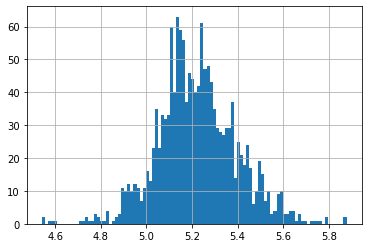

In [3]:
# Korelasyon matrislerinin doğruluğunu artırmak için öncelikle satış fiyatlarına 
# log transform uygula. 
trainData["SalePrice"]=np.log10(trainData["SalePrice"])
trainData["SalePrice"].hist(bins=100)
plt.show()

In [4]:
# Bu sütunlarda çok fazla sayıda Null değer var. 
dropCols = ["Alley","FireplaceQu","Fence","MiscFeature","Id","PoolQC"]
trainData.drop(dropCols,inplace=True,axis=1)

In [5]:
floatCols=trainData.columns[np.where(trainData[trainData.columns].dtypes==np.float64)[0]]
intCols=trainData.columns[np.where(trainData[trainData.columns].dtypes==np.int64)[0]]
objCols = trainData.columns[np.where(trainData[trainData.columns].dtypes == object)[0]]

### Float

In [6]:
# GarageYrBlt -> Garage Age
trainData["GarageAge"] = trainData["GarageYrBlt"] - trainData["GarageYrBlt"].min()
trainData.drop("GarageYrBlt",inplace=True,axis=1)

# Float col. isimlerini yeniden al
floatCols=trainData.columns[np.where(trainData[trainData.columns].dtypes==np.float64)[0]]

In [7]:
# LotFrontage ve MasVnrArea -> log transform
trainData["LotFrontage"]=np.log10(trainData["LotFrontage"]+1)
trainData["MasVnrArea"]=np.log10(trainData["MasVnrArea"]+1)

### Int

In [8]:
# Az sayıda unique değer ,dolayısıyla düşük korelasyon.
dropCols = ["MiscVal","PoolArea","3SsnPorch","ScreenPorch",
"BsmtFinSF2","LowQualFinSF","YrSold","MoSold","EnclosedPorch","KitchenAbvGr"]
trainData.drop(dropCols,inplace=True,axis=1)
intCols=trainData.columns[np.where(trainData[trainData.columns].dtypes==np.int64)[0]]

In [9]:
#  YearBuilt -> Age
trainData["Age"] = trainData["YearBuilt"]-trainData["YearBuilt"].min()
trainData.drop("YearBuilt",inplace=True,axis=1)

#  YearRemodAdd -> RemodAge
trainData["RemodAge"] = trainData["YearRemodAdd"]-trainData["YearRemodAdd"].min()
trainData.drop("YearRemodAdd",inplace=True,axis=1)

# intCols yeniden çek
intCols=trainData.columns[np.where(trainData[trainData.columns].dtypes==np.int64)[0]]

In [10]:
tCols = ["LotArea","BsmtFinSF1","BsmtUnfSF",
"TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea",
"GarageArea","WoodDeckSF","OpenPorchSF"]
trainData[tCols]= np.log10(trainData[tCols]+1)

In [11]:
dropCols=[
    "TotRmsAbvGrd", # GrLivArea ile 0.81 korelasyonu var.
    "1stFlrSF",
    "2ndFlrSF"
]
trainData.drop(dropCols,axis=1,inplace=True)
intCols=trainData.columns[np.where(trainData[trainData.columns].dtypes==np.int64)[0]]

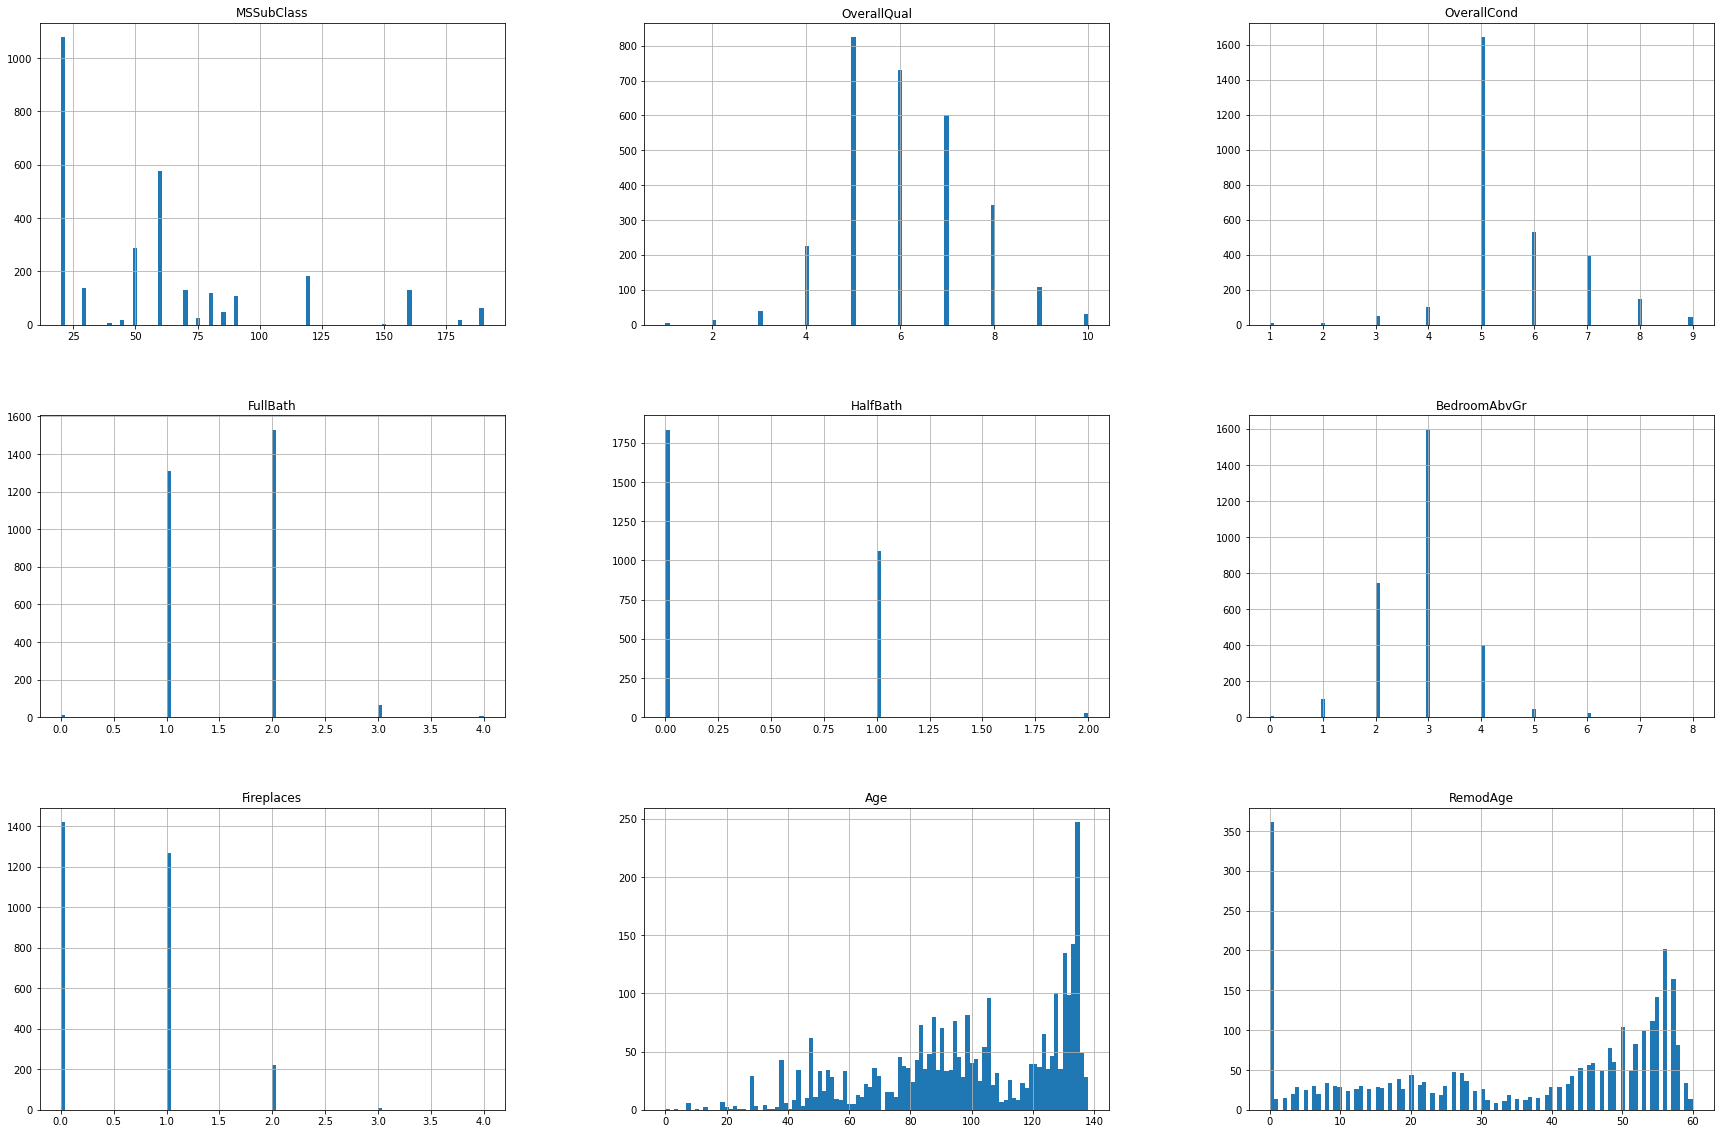

In [95]:
trainData[intCols].hist(bins=100,figsize=(30,20))
plt.show()

In [96]:
trainData.drop(objCols,axis=1,inplace=True)

In [12]:
orgVals = {}
for col in objCols:
    uniqueVals = trainData[col].unique()
    orgVals[col] = uniqueVals
    trainData[col].replace(uniqueVals,range(0,uniqueVals.shape[0],1),inplace=True)

In [13]:
retainCols = ["MSZoning","LotShape","Neighborhood","Exterior1st","Exterior2nd",
"MasVnrType","ExterQual","Foundation","BsmtQual","BsmtExposure","BsmtFinType1",
"HeatingQC","KitchenQual","GarageType","GarageFinish"]
for ret in retainCols:
    objCols=np.delete(objCols,np.where(objCols == ret)[0],axis=0)
trainData.drop(objCols,inplace=True,axis=1)
objCols = retainCols

In [14]:
for col in objCols:
    trainData[col].replace(range(0,orgVals[col].shape[0],1),orgVals[col],inplace=True)

In [15]:
dummies = pd.get_dummies(trainData[objCols],drop_first=True)
trainData=pd.concat([trainData,dummies],axis=1)
trainData.drop(objCols,inplace=True,axis=1)

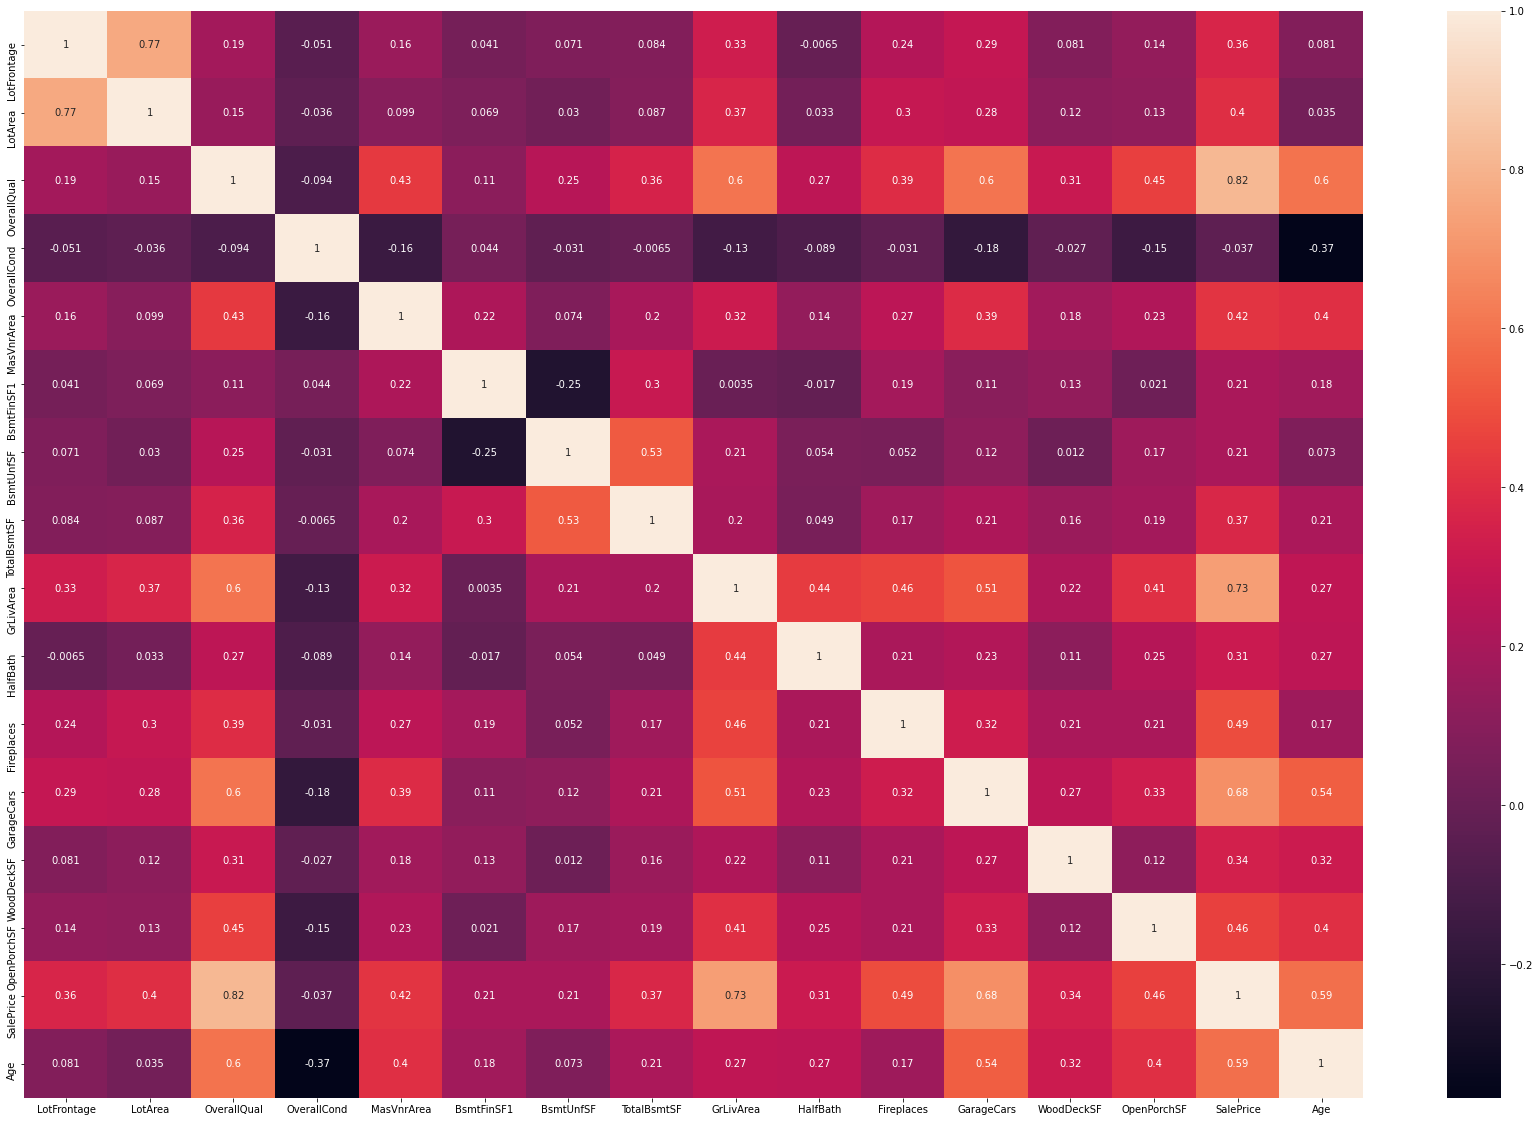

In [45]:
corrMatrix=trainData.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corrMatrix ,annot=True)
plt.show()

In [16]:
dropCols = ["GarageAge","RemodAge","MSSubClass","BsmtHalfBath","GarageArea",
"FullBath","BsmtFullBath","BedroomAbvGr"]
trainData.drop(dropCols,axis=1,inplace=True)

In [78]:
salePrices=trainData.loc[:1460-1,"SalePrice"].values
features = trainData.drop("SalePrice",axis=1).values

In [79]:
imp_mean = SimpleImputer()
features=imp_mean.fit(features).transform(features)

In [80]:
features=RobustScaler().fit(features).transform(features)

In [146]:
pca = PCA(n_components=3)
pca.fit(features[:,:24])
lfeatures=pca.transform(features[:,:24])

In [147]:
pca.score(features[:,:24])

-21.1390073062791

In [148]:
trainFeatures = lfeatures[:1460]
predFeatures = lfeatures[1460:]

In [149]:
x_train,x_test,y_train,y_test=train_test_split(trainFeatures,salePrices,test_size= 0.2,random_state=0)

In [45]:
parameters = {"max_depth":[2,3,4,5,6,7]}
#parameters = {"alpha":[0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.5,5,7.5,10]}
gSearch = GridSearchCV(estimator = GradientBoostingRegressor(),param_grid= parameters)
gSearch.fit(x_train,y_train)
gSearch.best_estimator_
gSearch.best_params_

KeyboardInterrupt: 

In [150]:
fSelecter = GradientBoostingRegressor(random_state=0,max_depth=3,learning_rate=0.1,tol=1e-5)
fSelecter.fit(x_train,y_train)
print(fSelecter.score(x_test,y_test))

0.689421644309741


In [125]:
pred = fSelecter.predict(x_test)

gt = np.power(10,y_test)

pred = np.power(10,pred)

m = tf.keras.metrics.RootMeanSquaredError()
m.reset_state()
m.update_state(np.log(gt),np.log(pred))
m.result().numpy()

0.20212573

In [181]:
plt.plot(fSelecter.coef_,"r*")

AttributeError: 'GradientBoostingRegressor' object has no attribute 'coef_'

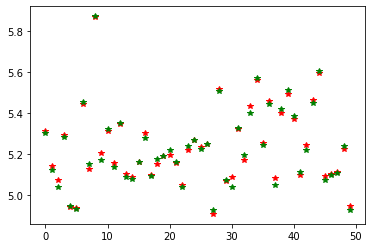

In [182]:
predictions = fSelecter.predict(x_test)
plt.plot((predictions)[:50],"r*")
plt.plot((y_test)[:50],"g*")
plt.show()

In [183]:
predictions = fSelecter.predict(predFeatures)

In [184]:
submisson=pd.read_csv("sample_submission.csv")

In [185]:
submisson["SalePrice"]=np.power(10,predictions)

In [186]:
submisson.to_csv("submisson.csv",index=False)

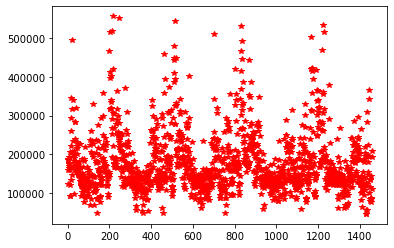

In [188]:
plt.plot(submisson["SalePrice"],"r*")